In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel
import elm

from scipy.optimize import curve_fit
from scipy import stats

import dataloader
import preprocessing
import data_augmentation
import add_features

'''
# Import module from previous folder
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
'''


# Load data

In [38]:
# Load preprocessed ERSP data
ERSP_all, tmp_all, freqs = dataloader.load_data()

ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 60)

Shape of ERSP_all:  (452, 12, 114, 200)
Shape of tmp_all:  (452, 3)
Shape of freqs:  (114,)
> Remove 9 trials (60.000 sec)


In [8]:
# Load raw data
# Read pickle file
with open('./ERSP_from_raw.data', 'rb') as fp:
    dict_ERSP = pickle.load(fp)
    
ERSP_all, tmp_all, freqs, t = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq'], dict_ERSP['t']
print('Shape of ERSP_all: ', ERSP_all.shape)
print('Shape of tmp_all: ', tmp_all.shape)
print('Shape of freqs: ', freqs.shape)
print('Shape of t: ', t.shape)

Shape of ERSP_all:  (1084, 12, 57, 172)
Shape of tmp_all:  (1084,)
Shape of freqs:  (57,)
Shape of t:  (172,)


# Data preprocessing

In [64]:
#ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 25)
ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all)

## Remain original ERSP

In [65]:
num_epoch = ERSP_all.shape[0]
method = 3 # 1,2,3

if method != 3:
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    
else:
    '''
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''
    '''
    # Average power over channels (LDA directly)
    ERSP_all = np.mean(ERSP_all, axis=2)
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''
    ERSP_all = preprocessing.bandpower(ERSP_all, freqs, 5, 15)
    print('Shape of ERSP_all: ', ERSP_all.shape)
    

Shape of ERSP_all:  (452, 12)


## Trim mean

In [4]:
ERSP_all, new_SLs = preprocessing.trimMean(ERSP_all, SLs, freqs)
Y = preprocessing.make_target(new_SLs)

method = 3

## Bandpower

In [4]:
ERSP_1 = preprocessing.bandpower(ERSP_all, freqs, 5, 10)
ERSP_2 = preprocessing.bandpower(ERSP_all, freqs, 10, 15)
ERSP_all = np.concatenate((ERSP_1, ERSP_2), axis=1)

threshold = np.mean(SLs)+np.std(SLs)
print(threshold)
Y = preprocessing.make_target(SLs, threshold)

method = 3

25.554513197351692


# Holdout Method

## Split data

In [5]:
# Split for training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(ERSP_all, Y, test_size=0.1, random_state=42)
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

X_train shape :  (406, 1368)
X_test shape :  (46, 1368)


## PCA (1) Largest eigenvalues

In [5]:
# Apply PCA to training data and testing data
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

NameError: name 'X_train' is not defined

## PCA (2) Most correlated

In [5]:
def PCA_corr(X_train, X_test, Y_train):
    # PCA fit
    num_train = X_train.shape[0]
    mean_X = 1/num_train * np.dot(X_train.T, np.ones((num_train,1))).T
    cen_X_train = X_train - mean_X
    cov_X_train = 1/num_train * np.dot(cen_X_train.T, cen_X_train)
    w, v = np.linalg.eig(cov_X_train)

    # Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = np.argsort(w)[::-1]
    sorted_v = v[:, sorted_indices]
    sorted_w = np.sort(w)[::-1]

    # Retain PCs with 80% eigenvalues
    ratios = np.add.accumulate(sorted_w.real)/np.sum(sorted_w.real)
    num_PCs = np.sum(ratios<=0.8)
    PCs = sorted_v[:, :num_PCs]

    # PCA predict
    X_train = np.dot(cen_X_train, PCs)

    # Find two PCs correlated most strongly with SLs
    corr_coef = np.zeros(num_PCs)
    for i in range(num_PCs):
        corr_coef[i] = abs(np.corrcoef(X_train[:,i], Y_train[:,1])[0,1])

    #print(corr_coef)
    max_1_index = np.argmax(corr_coef)
    #print('Max: ', max_1_index)
    corr_coef[max_1_index] = 0
    max_2_index = np.argmax(corr_coef)
    #print('Second: ', max_2_index)
    PC_2 = sorted_v[:, [max_1_index, max_2_index]]


    # PCA predict
    X_train = abs(np.dot(cen_X_train, PC_2))
    X_test = abs(np.dot(X_test-mean_X, PC_2))

    #print('X_train shape : ', X_train.shape)
    #print('X_test shape : ', X_test.shape)
    
    return X_train, X_test

In [7]:
X_train, X_test = PCA_corr(X_train, X_test, Y_train)

[0.10016149 0.13321825 0.19431854 0.1501953  0.1506912  0.05088907
 0.14942456 0.12343108 0.06527064 0.0030398  0.02589858 0.06059784
 0.06922075 0.04778581 0.0834417  0.08851105 0.09370633 0.03329117
 0.08084067 0.00824471 0.00701375 0.09780048 0.05044458 0.0233989 ]
Max:  2
Second:  4


In [8]:
# Sort SLs in increasing order
sorted_indices = np.argsort(Y_train[:,1])
sorted_x = X_train[sorted_indices, :]
sorted_y = Y_train[sorted_indices, :]

# Curve fitting
def func(X, a, b, c):
    x1, x2 = X
    return a + b*x1 + c*x2

xdata = (sorted_x[:,0], sorted_x[:,1])
ydata = sorted_y[:,1]
popt, pcov = curve_fit(func, xdata, ydata)

Text(0.5, 1.0, 'r = 0.043601')

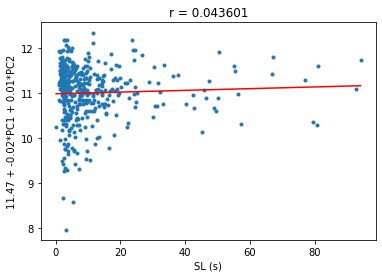

In [9]:
# Plot them
y_reg = func(xdata, popt[0], popt[1], popt[2])
plt.scatter(ydata, y_reg, marker = '.')

slope, intercept, r_value, p_value, std_err = stats.linregress(ydata, y_reg)
y_range = np.linspace(np.min(ydata), np.max(ydata), 100)
plt.plot(y_range, slope*y_range+intercept, 'r-')

plt.xlabel('SL (s)')
plt.ylabel('%.2f + %.2f*PC1 + %.2f*PC2'%(popt[0],popt[1],popt[2]))
plt.title('r = %f'%(np.corrcoef(y_reg, ydata)[0,1]))


# Leave-one-out cross validation

In [ ]:
X_all = ERSP_all

test_acc_SL = []
thresholds = list(range(1,50))

for threshold in thresholds:
    Y = preprocessing.make_target(SLs, float(threshold))
    
    train_acc_list = []
    test_acc_list = []
    loo = LeaveOneOut()
    for i, (train_index, test_index) in enumerate(loo.split(X_all)):

        # No trim mean
        # Split data
        X_train, X_test = X_all[train_index, :], X_all[test_index, :]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        if method == 1:
            pca = PCA(n_components=2)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            # PCA
            X_train, X_test = PCA_corr(X_train, X_test, Y_train)

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]

        '''
        # Trim mean after removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        X_train, new_SLs = trimMean(X_train, SLs[train_index], freqs)
        X_test = bandpower(X_test, freqs, 10, 15)

        # Let mean of SLs be the threshold
        threshold = np.mean(new_SLs) 
        Y_train = np.asarray(new_SLs >= threshold, float)
        Y_test = np.asarray(SLs[test_index] >= threshold, float)
        '''

        '''
        # Trim mean before removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]
        '''

        # LDA
        clf = svm.SVC()
        clf.fit(X_train, Y_train)

        num_train = len(Y_train)
        pred_train = clf.predict(X_train)
        train_acc = np.sum(pred_train == Y_train)/num_train*100
        #print('Training Accuracy : %f'%(train_acc))
        train_acc_list.append(train_acc)

        num_test = len(Y_test)
        pred_test = clf.predict(X_test)
        test_acc = np.sum(pred_test == Y_test)*100
        #print('Testing Accuracy : %f'%(test_acc))
        test_acc_list.append(test_acc)

        # print('Iteration %d: (%f, %f)'%(i, train_acc, test_acc))
        
    print('Threshold %d: %f'%(threshold, sum(test_acc_list)/len(test_acc_list)))
    test_acc_SL.append(sum(test_acc_list)/len(test_acc_list))
    

In [6]:
test_acc_array = np.asarray(test_acc_list)
false_trials = SLs[np.where(test_acc_array==0)[0]]
true_trials = SLs[np.where(test_acc_array==100)[0]]
print('False trials, Min: %f, Max: %f'%(np.min(false_trials), np.max(false_trials)))
print('True trials, Min: %f, Max: %f'%(np.min(true_trials), np.max(true_trials)))

False trials, Min: 26.693359, Max: 94.105469
True trials, Min: 0.152344, Max: 25.238281


In [6]:
print('Training accuracy: %f'%(sum(train_acc_list)/len(train_acc_list)))
print('Testing accuracy: %f'%(sum(test_acc_list)/len(test_acc_list)))

Training accuracy: 91.150442
Testing accuracy: 91.150442


Text(0, 0.5, 'Accuracy (%)')

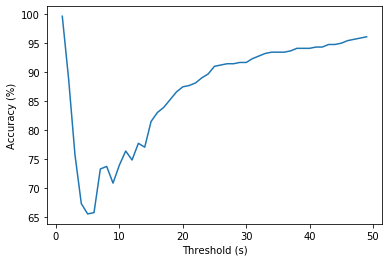

In [9]:
plt.plot(thresholds, test_acc_SL)
plt.xlabel('Threshold (s)')
plt.ylabel('Accuracy (%)')

In [6]:
ratios = []
for threshold in thresholds:
    ratio = max(np.sum(SLs<=threshold), np.sum(SLs>threshold))/len(SLs)
    ratios.append(ratio*100)

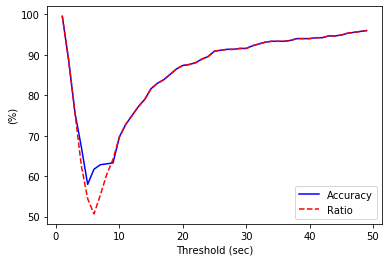

In [7]:
plt.plot(thresholds, test_acc_SL, 'b-', thresholds, ratios, 'r--')
plt.xlabel('Threshold (sec)')
plt.ylabel('(%)')
plt.legend(('Accuracy', 'Ratio'))

# Regression

In [3]:
def standard_error(pred, target):
    
    assert pred.shape[0] == target.shape[0]
    
    return (np.sum( np.power(pred-target,2) )/len(pred))**0.5

def plot_scatter(true, pred, fileName=None):
    
    sort_indices = np.argsort(true)
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].plot(range(len(true)), true[sort_indices], 'r.', range(len(true)), pred[sort_indices], 'b.')
    axs[0].set_xlabel('Record number')
    axs[0].set_ylabel('Solution latency')
    axs[0].legend(('True', 'Pred'))
    
    max_value = np.max(np.hstack((true, pred)))
    axs[1].scatter(true, pred, marker='.')
    axs[1].plot(range(int(max_value)),range(int(max_value)), 'r')
    axs[1].set_xlabel('True')
    axs[1].set_ylabel('Pred')
    axs[1].set_xlim([0, max_value])
    axs[1].set_ylim([0, max_value])
    axs[1].set_title('r = %.3f'%(np.corrcoef(true, pred)[0,1]))
    
    std = standard_error(true, pred)
    fig.suptitle('Standard error: %.3f'%(std))
    
    if fileName is not None:
        plt.savefig('./results/classical/%s_scatter.png'%(fileName))
        
def plot_residual(true, pred, fileName=None):
    
    record = range(len(true))
    residual = pred-true
    print('Mean of residual: %.3f'%(np.mean(pred-true)))
    
    fig, axs = plt.subplots(2,1, figsize=(8,5))
    axs[0].scatter(record, residual, marker='.')
    axs[0].set_xlabel('Record number')
    axs[0].set_ylabel('Residual')
    axs[0].set_title('Versus record number')
    
    axs[1].scatter(true, residual, marker='.')
    axs[1].set_xlabel('Target')
    axs[1].set_ylabel('Residual')
    axs[1].set_title('Versus target')
    
    fig.tight_layout(pad=2.0)
    
    if fileName is not None:
        plt.savefig('./results/classical/%s_residual.png'%(fileName))
        
def regression(X_train, Y_train, X_test, Y_test, regressor):
    
    results = regressor.fit(X_train,Y_train)
    pred_train = regressor.predict(X_train)
    pred_test = regressor.predict(X_test)
    
    train_std = mean_squared_error(Y_train, pred_train)**0.5
    test_std = mean_squared_error(Y_test, pred_test)**0.5
    train_r2 = r2_score(Y_train, pred_train)
    test_r2 = r2_score(Y_test, pred_test)
    
    return results, train_std, test_std, train_r2, test_r2, pred_train, pred_test

## Cross validation

In [40]:
mode_cv = 'KFold'
#aug_methods = ['Original', 'undersampling', 'SMOTER', 'add_noise']
aug_methods = ['Original']
center_flag = False
add_correlation = False
select_correlated = False
num_time = 1
method = 3
rgr_method = 1
num_results = len(aug_methods)

if mode_cv == 'KFold':
    num_fold = 10
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=23)
    
else:
    num_fold = ERSP_all.shape[0]
    kf = LeaveOneOut()
    
true_Y = np.zeros(tmp_all.shape[0])
pred_Y = np.zeros((tmp_all.shape[0], num_results))

train_std = np.zeros((num_fold, num_results))
test_std = np.zeros((num_fold, num_results))
train_r2 = np.zeros((num_fold, num_results))
test_r2 = np.zeros((num_fold, num_results))
train_base = np.zeros(num_fold)
test_base = np.zeros(num_fold)
train_base_r2 = np.zeros(num_fold)
test_base_r2 = np.zeros(num_fold)

curr_test = 0

for i, (train_index, test_index) in enumerate(kf.split(ERSP_all)):
    print('---Iteration %d---\n'%(i))
    
    # Standardize data
    X_all, Y = preprocessing.standardize(ERSP_all, tmp_all, train_indices=train_index, threshold=0.0, num_time=num_time)
    '''
    # Remove channels
    X_all = X_all[:,2:,:]
    '''
    num_channel = X_all.shape[1]
    if add_correlation:
        # Get correlation between channels
        correlations = add_features.get_correlations(X_all)
        corr_train = correlations[train_index,:]
        corr_test = correlations[test_index,:]
    
    if select_correlated:
        # Select correlated ERSP
        X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.95, train_indices=train_index)
        #select.append(select_indices)
    
    # Flatten X_all
    X_all = X_all.reshape((X_all.shape[0],-1))
    
    # Split data
    X_train, X_test_ori = X_all[train_index, :], X_all[test_index, :]
    Y_train, Y_test_ori = Y[train_index], Y[test_index]
    
    # Data augmentation
    aug_X_train, aug_Y_train = {}, {}
    
    aug_X_train['Original'], aug_Y_train['Original'] = X_train.copy(), Y_train.copy()
    if 'undersampling' in aug_methods:
        aug_X_train['undersampling'], aug_Y_train['undersampling'] = data_augmentation.aug(X_train, Y_train, 'undersampling')
    if 'SMOTER' in aug_methods:
        aug_X_train['SMOTER'], aug_Y_train['SMOTER'] = data_augmentation.aug(X_train, Y_train, 'SMOTER')
    if 'add_noise' in aug_methods:
        aug_X_train['add_noise'], aug_Y_train['add_noise'] = data_augmentation.aug(X_train, Y_train, 'add_noise', (10,1))
    
    for i_aug, aug_method in enumerate(aug_methods):
        
        X_train, Y_train = aug_X_train[aug_method], aug_Y_train[aug_method]
        X_test, Y_test = X_test_ori.copy(), Y_test_ori.copy()
        
        # Standardize before PCA
        if center_flag:
            X_train, X_test = preprocessing.center(X_train, X_test)
        
        # PCA
        if method == 1:
            pca = PCA(n_components=10)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test, num_features=5)
        elif method == 3:
            lower, higher = [4], [30]
            X_train = X_train.reshape((X_train.shape[0], num_channel, len(freqs), num_time))
            X_test = X_test.reshape((X_test.shape[0], num_channel, len(freqs), num_time))
            for i_time in range(num_time):
                X_train_t = X_train[:,:,:,i_time]
                X_test_t = X_test[:,:,:,i_time]

                X_train_t = preprocessing.bandpower(X_train_t, freqs, lower, higher).reshape((X_train.shape[0],-1))
                X_test_t = preprocessing.bandpower(X_test_t, freqs, lower, higher).reshape((X_test.shape[0],-1))

                if i_time == 0:
                    X_train_all, X_test_all = X_train_t, X_test_t
                else:
                    X_train_all = np.concatenate((X_train_all, X_train_t), axis=1)
                    X_test_all = np.concatenate((X_test_all, X_test_t), axis=1)
            
            X_train, X_test = X_train_all, X_test_all

        # Concatenate with correlations
        if add_correlation:
            '''
            pca = PCA(n_components=10)
            pca.fit(correlations[train_index,:])
            corr_train = pca.transform(correlations[train_index,:])
            corr_test = pca.transform(correlations[test_index,:])
            '''
            '''
            # Standardize power
            X_train, X_test = preprocessing.scale(X_train, X_test)
            # Standardize correlations
            corr_train, corr_test = preprocessing.scale(corr_train, corr_test)
            '''
            
            X_train = np.concatenate((X_train, corr_train), axis=1)
            X_test = np.concatenate((X_test, corr_test), axis=1)
            
        if rgr_method == 1:
            rgr = LinearRegression()
        elif rgr_method == 2:
            rgr = Ridge(alpha=1)
        elif rgr_method == 3:
            rgr = Lasso(alpha=0.5)
        elif rgr_method == 4:
            kernel = RBF(10, (1e-2,1e2)) + ConstantKernel(10, (1e-2,1e2))
            #kernel = RBF(10, (1e-5,1e2))
            rgr = GaussianProcessRegressor(kernel=kernel, random_state=0)
        
        _, train_std[i,i_aug], test_std[i,i_aug], train_r2[i,i_aug], test_r2[i,i_aug], pred_train, pred_test = \
            regression(X_train, Y_train, X_test, Y_test, rgr)
        print('%s: %f | %f, %f | %f\n'%(aug_method, train_std[i,i_aug], test_std[i,i_aug], 
                                        train_r2[i,i_aug], test_r2[i,i_aug]))
        pred_Y[curr_test:curr_test+len(test_index), i_aug] = pred_test
            
    true_Y[curr_test:curr_test+len(test_index)] = Y_test
    curr_test += len(test_index)
    
    train_baseline = np.array([np.mean(Y_train)]*Y_train.shape[0])
    test_baseline = np.array([np.mean(Y_train)]*Y_test.shape[0])
    print('Baseline: %f | %f\n'%(standard_error(train_baseline, Y_train), standard_error(test_baseline, Y_test)))
    train_base[i] = standard_error(train_baseline, Y_train)
    test_base[i] = standard_error(test_baseline, Y_test)
    train_base_r2[i] = r2_score(Y_train, train_baseline)
    test_base_r2[i] = r2_score(Y_test, test_baseline)
    

---Iteration 0---

Base threshold: 0.000000
Original: 10.133725 | 6.660173, 0.156913 | 0.181425

Baseline: 11.036541 | 7.458786

---Iteration 1---

Base threshold: 0.000000
Original: 9.562591 | 12.005676, 0.164058 | 0.127770

Baseline: 10.458938 | 12.857045

---Iteration 2---

Base threshold: 0.000000
Original: 9.781370 | 10.373297, 0.166340 | 0.069179

Baseline: 10.712857 | 10.862507

---Iteration 3---

Base threshold: 0.000000
Original: 9.661708 | 11.582399, 0.168708 | 0.040682

Baseline: 10.596855 | 11.843937

---Iteration 4---

Base threshold: 0.000000
Original: 10.084615 | 7.137590, 0.158642 | 0.160990

Baseline: 10.994334 | 7.911905

---Iteration 5---

Base threshold: 0.000000
Original: 9.739278 | 10.980641, 0.150521 | 0.173904

Baseline: 10.566971 | 12.081891

---Iteration 6---

Base threshold: 0.000000
Original: 10.053702 | 7.606177, 0.172033 | -0.169232

Baseline: 11.048910 | 7.192037

---Iteration 7---

Base threshold: 0.000000
Original: 9.894782 | 9.340603, 0.153190 | 0.2018

In [41]:
# Plot result
for i, aug_method in enumerate(aug_methods):
    print('%s: std (%f, %f), r2 (%f, %f)'%(aug_method, \
        np.mean(train_std[:,i]), np.mean(test_std[:,i]), np.mean(train_r2[:,i]), np.mean(test_r2[:,i])))

print('Baseline: std (%f, %f), r2 (%f, %f)'%(np.mean(train_base), np.mean(test_base), np.mean(train_base_r2)
                                            , np.mean(test_base_r2)))

Original: std (9.809045, 9.950566), r2 (0.163402, 0.089170)
Baseline: std (10.724236, 10.534950), r2 (0.000000, -0.016359)


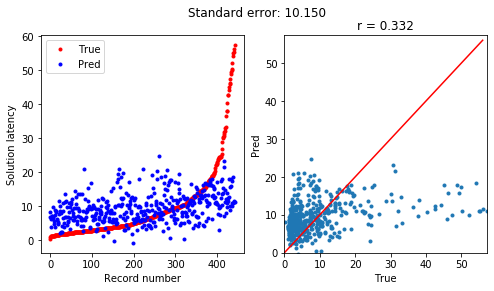

In [44]:
plot_scatter(true_Y, pred_Y[:,0])

Mean of residual: 0.002


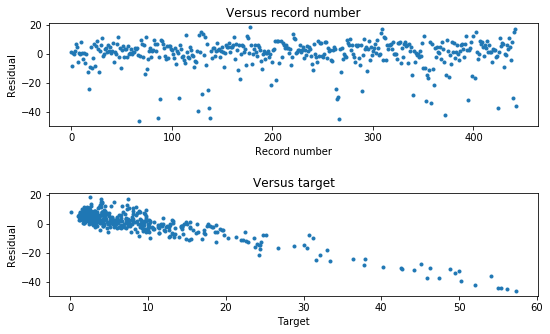

In [66]:
plot_residual(true_Y, pred_Y[:,0])

Best model so far: Correlated PCA, SMOTER, GPR

## Cross validation for each subject

In [23]:
add_CE = False
add_correlation = False
scale_data = True
subs = range(100,101)

record = {}
record['true_Y'], record['pred_Y'] = [], []
record['train_std'], record['test_std'] = [], []
record['train_r2'], record['test_r2'] = [], []
for i_sub, sub in enumerate(subs):
    with open('./raw_data/ERSP_from_raw_%d.data'%(sub), 'rb') as fp:
        dict_ERSP = pickle.load(fp)

    ERSP_all, tmp_all, freqs, t = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq'], dict_ERSP['t']
    
    # Remove trials with solution latency more than 60 sec
    ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 60)
    
    mode_cv = 'KFold'
    #aug_methods = ['Original', 'undersampling', 'SMOTER', 'add_noise']
    aug_methods = ['Original']
    method = 3
    rgr_method = 4
    num_results = len(aug_methods)

    if mode_cv == 'KFold':
        num_fold = 10
        kf = KFold(n_splits=num_fold, shuffle=True, random_state=23)

    else:
        num_fold = ERSP_all.shape[0]
        kf = LeaveOneOut()

    true_Y = np.zeros(tmp_all.shape[0])
    pred_Y = np.zeros((tmp_all.shape[0], num_results))

    train_std = np.zeros((num_fold, num_results))
    test_std = np.zeros((num_fold, num_results))
    train_r2 = np.zeros((num_fold, num_results))
    test_r2 = np.zeros((num_fold, num_results))
    train_base = np.zeros(num_fold)
    test_base = np.zeros(num_fold)
    train_base_r2 = np.zeros(num_fold)
    test_base_r2 = np.zeros(num_fold)

    curr_test = 0
    
    # Load conditional entropy
    if add_CE:
        with open('./raw_data/CE_sub%i'%(sub), 'rb') as fp:
            CE = pickle.load(fp)
        assert CE.shape[0] == ERSP_all.shape[0]
    for i, (train_index, test_index) in enumerate(kf.split(ERSP_all)):
        print('---Iteration %d---\n'%(i))

        # Standardize data
        X_all, Y = preprocessing.standardize(ERSP_all, tmp_all, train_indices=train_index, threshold=0.0)

        '''
        # Select correlated ERSP
        X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.95, train_indices=train_index)
        select.append(select_indices)
        '''

        # Flatten X_all
        X_all = X_all.reshape((X_all.shape[0],-1))

        # Split data
        X_train, X_test = X_all[train_index, :], X_all[test_index, :]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # Data preprocessing
        if method == 1:
            pca = PCA(n_components=30)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test, num_features=10)
        elif method == 3:
            X_train = X_train.reshape((X_train.shape[0],12,-1))
            X_test = X_test.reshape((X_test.shape[0],12,-1))

            X_train = preprocessing.bandpower(X_train, freqs, [4], [30])
            X_test = preprocessing.bandpower(X_test, freqs, [4], [30])

            X_train = X_train.reshape((X_train.shape[0],-1))
            X_test = X_test.reshape((X_test.shape[0],-1))
        
        # Scale data
        if scale_data:
            X_train, X_test = preprocessing.scale(X_train, X_test)
            
        if add_CE:
            CE_train, CE_test = CE[train_index,:], CE[test_index,:]

            # PCA to reduce CE
            pca = PCA(n_components=0.9)
            pca.fit(CE_train)
            CE_train = pca.transform(CE_train)
            CE_test = pca.transform(CE_test)

            # Scale CE
            CE_train, CE_test = preprocessing.scale(CE_train, CE_test)
            '''
            print('CE_train: (%s,%s)'%(np.mean(CE_train, axis=0), np.std(CE_train, axis=0)))
            print('CE_test: (%s,%s)'%(np.mean(CE_test, axis=0), np.std(CE_test, axis=0)))
            print('X_train: (%s,%s)'%(np.mean(X_train, axis=0), np.std(X_train, axis=0)))
            print('X_test: (%s,%s)'%(np.mean(X_test, axis=0), np.std(X_test, axis=0)))
            '''
            print('CE_train: ', CE_train.shape)

            X_train = np.concatenate((X_train, CE_train), axis=1)
            X_test = np.concatenate((X_test, CE_test), axis=1)
            
        if add_correlation:
            
            # Get correlation between channels
            correlations = add_features.get_correlations(X_all.reshape((X_all.shape[0],12,-1)))
            
            pca = PCA(n_components=0.9)
            pca.fit(correlations[train_index,:])
            corr_train = pca.transform(correlations[train_index,:])
            corr_test = pca.transform(correlations[test_index,:])
            print('corr_train: ', corr_train.shape)
            
            # Standardize correlations
            corr_train, corr_test = preprocessing.scale(corr_train, corr_test)
            
            X_train = np.concatenate((X_train, corr_train), axis=1)
            X_test = np.concatenate((X_test, corr_test), axis=1)
            

        # Data augmentation
        aug_X_train, aug_Y_train = {}, {}

        aug_X_train['Original'], aug_Y_train['Original'] = X_train.copy(), Y_train.copy()
        if 'undersampling' in aug_methods:
            aug_X_train['undersampling'], aug_Y_train['undersampling'] = data_augmentation.aug(X_train, Y_train, 'undersampling')
        if 'SMOTER' in aug_methods:
            aug_X_train['SMOTER'], aug_Y_train['SMOTER'] = data_augmentation.aug(X_train, Y_train, 'SMOTER')
        if 'add_noise' in aug_methods:
            aug_X_train['add_noise'], aug_Y_train['add_noise'] = data_augmentation.aug(X_train, Y_train, 'add_noise', (10,1))

        for i_aug, aug_method in enumerate(aug_methods):

            X_train, Y_train = aug_X_train[aug_method], aug_Y_train[aug_method]

            if rgr_method == 1:
                rgr = LinearRegression()
            elif rgr_method == 2:
                rgr = Ridge(alpha=1)
            elif rgr_method == 3:
                #kernel = RBF(10, (1e-5,1e2)) + ConstantKernel(10, (1e-3,1e3))
                kernel = RBF(10, (1e-5,1e2))
                rgr = GaussianProcessRegressor(kernel=kernel, random_state=0)
            elif rgr_method == 4:
                # Concatenate data for extreme learning machine
                train_data = np.concatenate((Y_train[:,np.newaxis], X_train), axis=1)
                test_data = np.concatenate((Y_test[:,np.newaxis], X_test), axis=1)
                
                elmk = elm.ELMKernel()
                elmk.search_param(train_data, cv="kfold", of="rmse", eval=10)
                pred_train = elmk.train(train_data).predicted_targets
                pred_test = elmk.test(test_data).predicted_targets
                '''
                params = ["sigmoid", 1, 500, False]
                elmr = elm.ELMRandom(params)
                #elmr.search_param(train_data, cv="kfold", of="rmse", eval=10)
                pred_train = elmr.train(train_data).predicted_targets
                pred_test = elmr.test(test_data).predicted_targets
                '''
                train_std[i, i_aug] = mean_squared_error(Y_train, pred_train)**0.5
                test_std[i, i_aug] = mean_squared_error(Y_test, pred_test)**0.5
                train_r2[i, i_aug] = r2_score(Y_train, pred_train)
                test_r2[i, i_aug] = r2_score(Y_test, pred_test)
            
            if rgr_method != 4:
                _, train_std[i,i_aug], test_std[i,i_aug], train_r2[i,i_aug], test_r2[i,i_aug], pred_train, pred_test = \
                    regression(X_train, Y_train, X_test, Y_test, rgr)
            print('%s: %f | %f, %f | %f\n'%(aug_method, train_std[i,i_aug], test_std[i,i_aug], 
                                            train_r2[i,i_aug], test_r2[i,i_aug]))
            pred_Y[curr_test:curr_test+len(test_index), i_aug] = pred_test

        true_Y[curr_test:curr_test+len(test_index)] = Y_test
        curr_test += len(test_index)

    record['true_Y'].append(true_Y)
    record['pred_Y'].append(pred_Y)
    record['train_std'].append(train_std)
    record['test_std'].append(test_std)
    record['train_r2'].append(train_r2)
    record['test_r2'].append(test_r2)


> Remove 45 trials (60.000 sec)
---Iteration 0---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  10.843170510887958
Kernel function:  linear  best cv value:  14.89666458103243
Kernel function:  poly  best cv value:  10.96697207109557
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -0.10773128023946994
Kernel Function:  rbf
Kernel parameters:  [-1.6953451183284336]

CV error:  10.843170510887958

Original: 12.091467 | 12.072913, -0.142071 | 0.058316

---Iteration 1---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  11.221972918908008
Kernel function:  linear  best cv value:  15.392771743751785
Kernel function:  poly  best cv value:  11.341705183945724
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -0.45133872057924784
Kernel Function:  rbf
Kernel parameters:  [-0.5685133974955149]

CV error:  11.221972918908008

Original: 12.425668 | 9.102416, -0.122775 | -0.232912

---Iteration 2---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  10.913048979363019
Kernel function:  linear  best cv value:  15.21613734354236
Kernel function:  poly  best cv value:  11.164836022693276
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -1.3435163733314122
Kernel Function:  rbf
Kernel parameters:  [-2.154508617862997]

CV error:  10.913048979363019

Original: 12.120078 | 9.785538, -0.095314 | 0.059402

---Iteration 3---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  11.360164198595776
Kernel function:  linear  best cv value:  15.16801768560785
Kernel function:  poly  best cv value:  12.644937938807733
##### Search complete #####

Regressor Parameters

Regularization coefficient:  0.885569110282221
Kernel Function:  rbf
Kernel parameters:  [-0.45722792723481287]

CV error:  11.360164198595776

Original: 12.759352 | 11.108670, -0.234180 | -0.013248

---Iteration 4---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  11.146985290164173
Kernel function:  linear  best cv value:  15.355599957753915
Kernel function:  poly  best cv value:  11.222441360791727
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -1.4406780264979928
Kernel Function:  rbf
Kernel parameters:  [-1.1052710638639682]

CV error:  11.146985290164173

Original: 12.226108 | 8.647489, -0.109072 | 0.190521

---Iteration 5---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  10.777211345737717
Kernel function:  linear  best cv value:  14.832794834744353
Kernel function:  poly  best cv value:  10.999278925561876
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -1.5137474783729379
Kernel Function:  rbf
Kernel parameters:  [-3.331346072715461]

CV error:  10.777211345737717

Original: 11.636620 | 12.188212, -0.060258 | 0.066505

---Iteration 6---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  10.670864352453227
Kernel function:  linear  best cv value:  14.827654583509405
Kernel function:  poly  best cv value:  10.771293130635206
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -0.800052361191979
Kernel Function:  rbf
Kernel parameters:  [-1.4054525507416695]

CV error:  10.670864352453227

Original: 11.984133 | 12.996327, -0.143987 | 0.048974

---Iteration 7---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  11.014160279856684
Kernel function:  linear  best cv value:  14.845030211823858
Kernel function:  poly  best cv value:  10.971191210363362
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -0.27230127600833043
Kernel Function:  poly
Kernel parameters:  [-1.213941207937835, 1.113317715991548]

CV error:  10.971191210363362

Original: 11.933606 | 12.199262, -0.106727 | 0.003298

---Iteration 8---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  11.000021126080748
Kernel function:  linear  best cv value:  15.17641618951696
Kernel function:  poly  best cv value:  11.268883763288759
##### Search complete #####

Regressor Parameters

Regularization coefficient:  0.38739507554343633
Kernel Function:  rbf
Kernel parameters:  [-2.0627140903210517]

CV error:  11.000021126080748

Original: 12.371121 | 10.244069, -0.146141 | 0.026006

---Iteration 9---

Base threshold: 0.000000
Standardize the data...
elmk
##### Start search #####


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  10.909752468869433
Kernel function:  linear  best cv value:  14.9457101740495
Kernel function:  poly  best cv value:  10.84334251870885
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -1.078622965966172
Kernel Function:  poly
Kernel parameters:  [0.8762011752628852, 1.1674616122747865]

CV error:  10.84334251870885

Original: 11.799316 | 12.287827, -0.091709 | 0.066319



Subject 100, Original: std (12.134747, 11.063272), r2 (-0.125223, 0.027318)


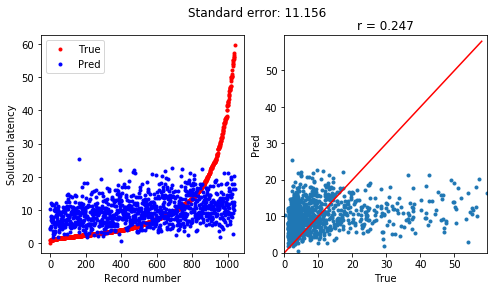

In [24]:
for i_sub, sub in enumerate(subs):
    train_std = record['train_std'][i_sub]
    test_std = record['test_std'][i_sub]
    train_r2 = record['train_r2'][i_sub]
    test_std = record['test_std'][i_sub]
    true_Y = record['true_Y'][i_sub]
    pred_Y = record['pred_Y'][i_sub]
    
    for i, aug_method in enumerate(aug_methods):
        print('Subject %d, %s: std (%f, %f), r2 (%f, %f)'%(sub, aug_method, \
            np.mean(train_std[:,i]), np.mean(test_std[:,i]), np.mean(train_r2[:,i]), np.mean(test_r2[:,i])))
        
        plot_scatter(true_Y, pred_Y[:,i], 'RawData_%s_sub%d_std_%.2f'%(aug_method, sub, np.mean(test_std[:,i])))

In [31]:
for i in range(11):
    print('Subject %d %d trials, %.3f'%(i, len(record['pred_Y'][i]), np.mean(record['true_Y'][i])))

Subject 0 59 trials, 14.760
Subject 1 70 trials, 12.131
Subject 2 174 trials, 4.753
Subject 3 137 trials, 6.997
Subject 4 43 trials, 19.712
Subject 5 94 trials, 10.580
Subject 6 112 trials, 7.853
Subject 7 60 trials, 14.220
Subject 8 154 trials, 9.338
Subject 9 56 trials, 14.464
Subject 10 80 trials, 16.862


## All data analysis

Base threshold: 5.000000
1. 0.192
2. 0.175


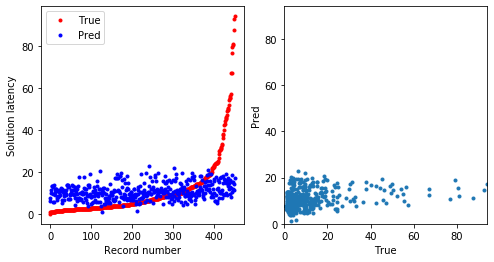

In [13]:
X, Y = preprocessing.standardize(ERSP_all, tmp_all, threshold=float(5))

# X, select_indices = preprocessing.select_correlated_ERSP(X, Y, threshold_corr=0.75)
X = X.reshape((X.shape[0],-1))

X = preprocessing.PCA_corr(X, Y, num_features=2)
rgr = LinearRegression()
rgr.fit(X, Y)

pred_Y = rgr.predict(X)

plot_scatter(Y, pred_Y)

In [ ]:
std_list = []
r2_list = []
for remove_threshold in range(2,80,2):
    
    X_train, Y_train = preprocessing.remove_trials(ERSP_all, SLs, remove_threshold)
    
    pca = PCA(n_components=0.9)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    
    rgr = svm.SVR()
    rgr.fit(X_train, Y_train)
    pred_Y = rgr.predict(X_train)
    
    error = standard_error(Y_train, pred_Y)
    r2 = r2_score(Y_train, pred_Y)
    std_list.append(error)
    r2_list.append(r2)
    print('%d: %f, %f'%(remove_threshold, error, r2))

(array([ 3., 50., 56., 54., 38., 24., 22., 21., 16., 21., 19.,  7., 11.,
        12.,  6.,  9.,  6.,  4.,  6.,  6.,  4.,  1.,  1.,  4.,  2.,  7.,
         2.,  0.,  1.,  0.,  1.,  1.,  2.,  3.,  1.,  1.,  0.,  0.,  1.,
         0.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0.15234375,  1.091875  ,  2.03140625,  2.9709375 ,  3.91046875,
         4.85      ,  5.78953125,  6.7290625 ,  7.66859375,  8.608125  ,
         9.54765625, 10.4871875 , 11.42671875, 12.36625   , 13.30578125,
        14.2453125 , 15.18484375, 16.124375  , 17.06390625, 18.0034375 ,
        18.94296875, 19.8825    , 20.82203125, 21.7615625 , 22.70109375,
        23.640625  , 24.58015625, 25.5196875 , 26.45921875, 27.39875 

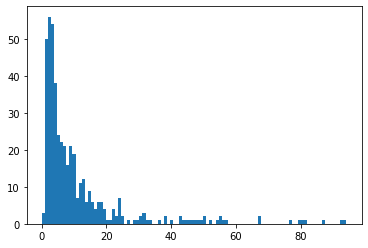

In [18]:
plt.hist(SLs, bins=100)

In [10]:
SLs = tmp_all[:,2]
np.sum(SLs<=np.quantile(SLs, 0.2))/len(SLs)

0.2013274336283186

In [8]:
np.quantile(SLs, 0.25)

3.02001953125

In [3]:
import elm

# download an example dataset from
# https://github.com/acba/elm/tree/develop/tests/data


# load dataset
data = elm.read("iris.data")

# create a classifier
elmk = elm.ELMKernel()

# split data in training and testing sets
# use 80% of dataset to training and shuffle data before splitting
tr_set, te_set = elm.split_sets(data, training_percent=.8, perm=True)

# search for best parameter for this dataset
# define "kfold" cross-validation method, "accuracy" as a objective function
# to be optimized and perform 10 searching steps.
# best parameters will be saved inside 'elmk' object
elmk.search_param(tr_set, cv="kfold", of="accuracy", eval=10)



#train and test
# results are Error objects
tr_result = elmk.train(tr_set)
te_result = elmk.test(te_set)

print(te_result.get_accuracy)
#print(te_result)

elmk
##### Start search #####
Kernel function:  rbf  best cv value:  0.9333333333333331
Kernel function:  linear  best cv value:  0.9749999999999999
Kernel function:  poly  best cv value:  0.9749999999999999
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -1.4121765752567652
Kernel Function:  linear
Kernel parameters:  []

CV error:  0.9749999999999999

<bound method Error.get_accuracy of <elm.mltools.Error object at 0x7ff0bf5c0f50>>
